Имеется 400 избражений лиц, 200 мужчин и 200 женщин. Нужно построить модель, которая по изображению будет определять пол человека. В качестве тестовой выборки есть по 100 изображений лиц каждого пола.

***#1.*** Загрузим необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.pyplot import subplots

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [3]:
import torch
import random
import torchvision 
from torchvision import transforms, models

In [4]:
#для работы с папками и файлами
import os
import shutil
from tqdm import tqdm

# LBP преобразование и логистическая регрессия

In [5]:
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

class_names = ['M', 'W']

data_root = './face'
os.listdir(data_root)

['test', 'train']

In [6]:
#создадим папки
for dir_name in [train_dir, val_dir]:
    for class_n in class_names:
        os.makedirs(os.path.join(dir_name, class_n), exist_ok = True)
        
#Делаем разбивку данных, на обучение и валидацию (понадобится для нейросетевых моделей). 
#В валидацию будет попадать каждое пятое изображение.
for class_n in class_names: 
    source_dir = os.path.join(data_root, 'train', class_n)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i%5 != 0:
            dest_dir = os.path.join(train_dir, class_n)
        else:
            dest_dir = os.path.join(val_dir, class_n)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|███████████████████████████████████████| 200/200 [00:00<00:00, 306.26it/s]


***#2*** напишем функцию для LBP преобразования (локального двоичного разбиения)

In [7]:
def LBP(image):
    try:
        image_array = np.array(image)
        lbp_array = np.zeros(image_array.shape)
    
        for i in range(1, image_array.shape[0]-1):
            for j in range(1, image_array.shape[1]-1):
            
                if image_array[i-1, j-1] < image_array[i,j]:
                    a1 = 0
                else:
                    a1 = 1
                
                if image_array[i-1, j] < image_array[i,j]:
                    a2 = 0
                else:
                    a2 = 1

                if image_array[i-1, j+1] < image_array[i,j]:
                    a3 = 0
                else:
                    a3 = 1

                if image_array[i, j-1] < image_array[i,j]:
                    a4 = 0
                else:
                    a4 = 1

                if image_array[i, j+1] < image_array[i,j]:
                    a5 = 0
                else:
                    a5 = 1

                if image_array[i+1, j-1] < image_array[i,j]:
                    a6 = 0
                else:
                    a6 = 1

                if image_array[i+1, j] < image_array[i,j]:
                    a7 = 0
                else:
                    a7 = 1

                if image_array[i+1, j+1] < image_array[i,j]:
                    a8 = 0
                else:
                    a8 = 1
                
                lbp_array[i, j] = (a1*(2**7))+(a2*(2**6))+(a3*(2**5))+(a4*(2**4))+(a5*(2**3))+(a6*(2**2))+(a7*2)+a8
        return lbp_array
    
    except:
        print('ERROR in "LBP"!!!')

***#3*** Разобьем изображение на 5 на 5 прямоугольных областейдля каждой области вычислим число пикселей у которых интенсивность равна заданному числу из диапазона от 0 до 255 (для уменьшения пространства признаков мы этот диапазон разобьем на 10 частей и будем вычислять число пикселей у которых интенсивность равна заданному диапазону).

In [8]:
def imhist_5(image, h_left, h_right, w_left, w_right):
    try:
        D = np.zeros(10) #

        for i in range(h_left, h_right):
            for j in range (w_left, w_right):
            
                if (image[i,j] < 26 and image[i,j]  >= 0 ):
                    D[0] += 1

                if (image[i,j]  < 52 and image[i,j]  >= 26 ):
                    D[1] += 1

                if (image[i,j]  < 78 and image[i,j]  >= 52 ):
                    D[2] += 1

                if (image[i,j]  < 104 and image[i,j]  >= 78 ):
                    D[3] += 1

                if (image[i,j]  < 130 and image[i,j]  >= 104 ):
                    D[4] += 1

                if (image[i,j]  <= 155 and image[i,j]  >= 130 ):
                    D[5] += 1

                if (image[i,j]  <= 180 and image[i,j]  > 155 ):
                    D[6] += 1

                if (image[i,j]  <= 205 and image[i,j]  > 180 ):
                    D[7] += 1

                if (image[i,j]  <= 230 and image[i,j]  > 205 ):
                    D[8] += 1

                if (image[i,j]  <= 255 and image[i,j]  > 230 ):
                    D[9] += 1
        return D
    
    except:
        print('ERROR in "imhist_5"!!!')

***#4.*** Реализуем функциию, которая будет ставить изображение в соответствие вектор признак (размерность 5*5*10) 

In [9]:
def extract_features_lbp(image_lbp):
    try:
        dw = 22
        dh = 23
    
        #ans = np.zeros((1,1))
    
        for k in range(5):
        
            if k == 0:
                h_left = 0
            else:
                h_left = h_right

            h_right = k*dh
        
            for t in range(5):
            
                if t == 0:
                    w_left = 0
                else:
                    w_left = w_right
        
                w_right = t*dw
        
                if k == 0 and t == 0:
                
                    ans = imhist_5(image_lbp, h_left, h_right, w_left, w_right)
                
                else:
                    ans = np.concatenate((ans, imhist_5(image_lbp, h_left, h_right, w_left, w_right)))
        return ans
    
    except:
        print('ERROR in "extract_features_lbp"!!!')

***#5.*** Протестируем работу функций

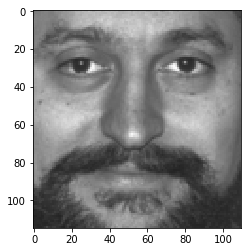

In [10]:
image_test = Image.open(os.path.join(data_root, train_dir, class_names[0], 
                                     os.listdir(os.path.join(data_root, train_dir, class_names[0]))[152]))
plt.imshow(image_test)
plt.show()

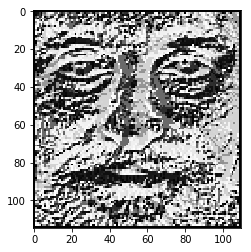

In [11]:
lbp_I = LBP(image_test)
plt.imshow(lbp_I, cmap='gray')
plt.show()

In [12]:
proba = extract_features_lbp(lbp_I)
proba.shape

(250,)

***#6.*** Напишем функцию для преобразования изображений в датасет

In [13]:
def extract_in_folder(name_folder, class_names):
    try:
        df = pd.DataFrame()

        for class_n in class_names: 
            for i, file_name in enumerate(tqdm((os.listdir(os.path.join(name_folder, class_n))))):
                image = Image.open(os.path.join(name_folder, class_n,file_name))
            
                new = LBP(image)
                new_2 = extract_features_lbp(new)
            
                tmp = pd.DataFrame([new_2])
                if class_n == 'W':
                    tmp['is_woman'] = 1
                else:
                    tmp['is_woman'] = 0
                
                tmp['name'] = file_name
            
                df = pd.concat([df, tmp])
            
        return df.sample(frac = 1, random_state = 100).reset_index(drop=True)
    
    except:
        print('ERROR in "extract_in_folder"!!!')

***#7.*** Сформируем датасеты

In [14]:
train = extract_in_folder(os.path.join(data_root, train_dir), class_names)
print(train.shape)

100%|████████████████████████████████████████| 200/200 [00:36<00:00,  5.49it/s]

(400, 252)


In [15]:
test = extract_in_folder(os.path.join(data_root, test_dir), class_names)
print(test.shape)

100%|████████████████████████████████████████| 100/100 [00:16<00:00,  6.13it/s]

(200, 252)


***#8*** Извлекем признаки и отделим целевой

In [16]:
features_train = train.drop(['is_woman', 'name'], axis=1)
target_train = train['is_woman']

features_test = test.drop(['is_woman', 'name'], axis=1)
target_test = test['is_woman']

***#9*** Отмасштабируем данные

In [17]:
scale = StandardScaler()

In [18]:
scale.fit(features_train)
features_train.head()

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,72.0,41.0,8.0,5.0,69.0,20.0,5.0,13.0,45.0,228.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,113.0,92.0,12.0,8.0,45.0,22.0,7.0,7.0,51.0,149.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,72.0,43.0,11.0,8.0,74.0,49.0,6.0,8.0,38.0,197.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,58.0,45.0,11.0,5.0,68.0,63.0,2.0,11.0,55.0,188.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,72.0,44.0,10.0,11.0,52.0,46.0,9.0,18.0,52.0,192.0


In [19]:
features_train = pd.DataFrame(scale.transform(features_train))
features_test = pd.DataFrame(scale.transform(features_test))

features_train.head()

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.556721,-0.721941,-1.153641,-1.033020,0.811123,-0.664677,-0.938506,-0.200902,-0.323737,1.079573
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.037522,2.311551,-0.500020,-0.245957,-0.389799,-0.516848,-0.429831,-1.165232,0.061664,-1.041185
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.556721,-0.602981,-0.663425,-0.245957,1.061315,1.478846,-0.684168,-1.004510,-0.773372,0.247377
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.101097,-0.484020,-0.663425,-1.033020,0.761084,2.513650,-1.701519,-0.522345,0.318598,0.005772
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.556721,-0.543501,-0.826830,0.541106,-0.039530,1.257102,0.078845,0.602706,0.125898,0.113152


***#10.*** Обучим модель логистической регрессии. Т.к. классы сбалансированы и не отдается препочтение какому-либо из них, то в качестве метрики будем использовать ***accuracy***

In [20]:
log_reg = LogisticRegression(random_state=100)

In [21]:
params = {'C': np.linspace(0.001,1.0,55)}

#scoring по умолчанию accurancy
gs = GridSearchCV(estimator = log_reg, 
                      param_grid = params, 
                      cv = 5, 
                      scoring = 'accuracy', 
                      n_jobs=-1
)

In [22]:
gs.fit(features_train, target_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=100, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([0.001 , 0.0195, 0.038 , 0.0565, 0.075 , 0.0935, 0.112 , 0.1305,
       0.149 , 0.1675, 0.186 , 0.2045, 0.223 , 0.2415, 0.26  , 0.2785,
       0.297 , 0.3155, 0.334 , 0.3525, 0.371 , 0.3895, 0.408 , 0.4265,
       0.445 , 0.4635, 0.482 , 0.5005, 0.519 , 0.5375, 0.556 , 0.5745,...65, 0.815 , 0.8335, 0.852 , 0.8705,
       0.889 , 0.9075, 0.926 , 0.9445, 0.963 , 0.9815, 1.    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [23]:
print('Лучшие гиперпараметры: ', gs.best_params_)
print('Лучший score на тренировочной выборке: ', gs.best_score_)

Лучшие гиперпараметры:  {'C': 0.0935}
Лучший score на тренировочной выборке:  0.915


In [24]:
log_reg = gs.best_estimator_

In [25]:
#Проверка на тесте
predicted = log_reg.predict(features_test)

print('\naccuracy на тестовой выборке: ', accuracy_score(target_test, predicted))


accuracy на тестовой выборке:  0.855


In [26]:
print('Число неправильных классификаций', np.abs(target_test-predicted).sum())

Число неправильных классификаций 29


In [27]:
#функция для построения roc-кривой и AUC метрики
def ROC_curve_AUC(model, features, target):
    try:
        model.predict(features)
        score_one = model.predict_proba(features)[:, 1]
        auc_roc = round(roc_auc_score(target, score_one), 4)
    
        fpr, tpr, thresholds = roc_curve(target, score_one)

        plt.figure(figsize=(6,6))
        plt.plot(fpr, tpr)

        # ROC-кривая случайной модели
        plt.plot([0, 1], [0, 1], linestyle='--')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')

        plt.title('ROC-кривая, AUC = '+str(auc_roc))
        plt.show()

    except:
        print('ERROR in "ROC_curve_AUC"!!!')

***#11*** Построим ROC-кривую и вычислим ROC-AUC

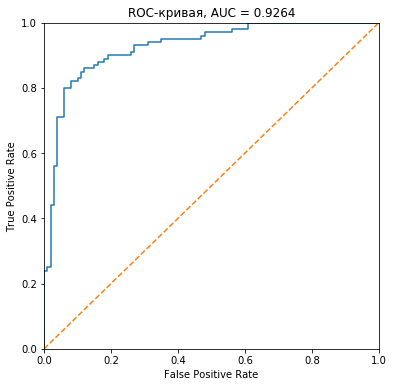

In [28]:
ROC_curve_AUC(log_reg, features_test, target_test)

In [29]:
#список файлов с ошибкой в классификации
predicted = pd.Series(predicted)
test.loc[(target_test - predicted).abs() > 0]['name'].sort_values()

11     1331.png
0      1333.png
175    1337.png
72     1355.png
32     1358.png
58     1359.png
51     1360.png
33     1369.png
139    1373.png
5      1374.png
40     1375.png
56     1399.png
124    1400.png
127     206.png
44      208.png
77      211.png
145     214.png
154     228.png
143     231.png
128     237.png
93      238.png
90      252.png
188     254.png
153     257.png
70      258.png
9       270.png
138     279.png
194     280.png
2       300.png
Name: name, dtype: object

#### Проверим на собственном фото работу модели

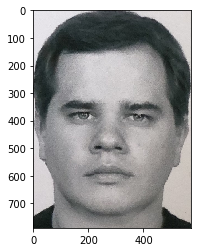

(573, 789)

In [30]:
i = Image.open('tim.jpg')
plt.imshow(i, cmap = plt.get_cmap('gray'))
plt.show()

size = (110, 115)
gray = i.convert('L')
gray.size

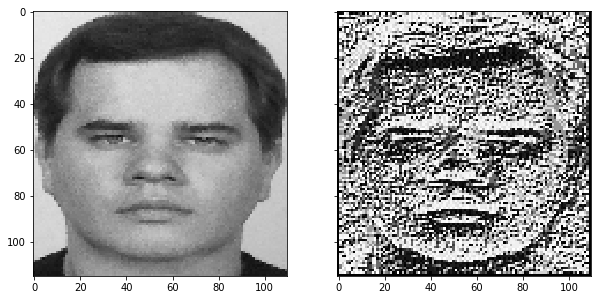

Мужчина


In [31]:
gray = gray.resize(size)
img = LBP(gray)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (10, 5))
ax1.imshow(gray, cmap = plt.get_cmap('gray'))
ax2.imshow(img, cmap = plt.get_cmap('gray'))
plt.show()

proba = pd.DataFrame([extract_features_lbp(img)])

if log_reg.predict(proba) == 0:
    print('Мужчина')
else:
    print('Женщина')

### Вывод  
Получили значение метрики 85.5% на тесте. Будем отталкиваться от этого значения при использовании нейросетевых моделей.